In [1]:
import os
import sys
from collections import namedtuple

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import utide
from joblib import Parallel, delayed
from matplotlib import dates as mdates
from matplotlib import pyplot as plt
from scipy.signal import argrelmax, argrelmin, find_peaks
from sklearn.linear_model import LinearRegression

sys.path.append("..")
from src import definitions as defs
from src import features, models

%load_ext autoreload
%autoreload 2
%matplotlib widget
%config Completer.use_jedi = False

In [2]:
wdir = defs.ROOT / "data"

In [3]:
tides = features.load_tide(wdir, "interim/tides-50yr-30s.feather")
tides = tides.to_frame(name="elevation")
tides = tides.iloc[::2*60].loc[:"2035"]

nodal_amp = 0.045
nodal_freq = 18.61
phase_start = pd.to_datetime("2015-10-01")

tides["elapsed"] = tides.index - tides.index[0]
tides["nodal"] = nodal_amp * np.sin(2 * np.pi * ((tides.index - phase_start.tz_localize(tz="Asia/Dhaka")) / (pd.Timedelta("365.25 days") * nodal_freq)) + np.pi / 2)
tides["elev_adj"] = tides.elevation - tides.nodal

In [4]:
freq = tides.index.freq
n_per_hour = pd.Timedelta("1 hour") / pd.Timedelta(freq)

tides[["high", "low"]] = False
distance = n_per_hour * 8
hi = find_peaks(x=tides.elevation.values, distance=distance)[0]
lo = find_peaks(x=tides.elevation.values * -1, distance=distance)[0]
tides.loc[tides.iloc[hi].index, "high"] = True
tides.loc[tides.iloc[lo].index, "low"] = True

tides["high_roll"] = tides.loc[tides.high == True].elevation.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=tides.index).interpolate(method="time", limit_direction="both")
tides["low_roll"] = tides.loc[tides.low == True].elevation.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=tides.index).interpolate(method="time", limit_direction="both")
tides["amp_roll"] = tides.high_roll - tides.low_roll

In [5]:
tides[["spring", "neap"]] = False
distance = n_per_hour * 24 * 11 # search distance in hours
hi = find_peaks(x=tides.amp_roll.values, distance=distance)[0]
lo = find_peaks(x=tides.amp_roll.values * -1, distance=distance)[0]
tides.loc[tides.iloc[hi].index, "spring"] = True
tides.loc[tides.iloc[lo].index, "neap"] = True

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
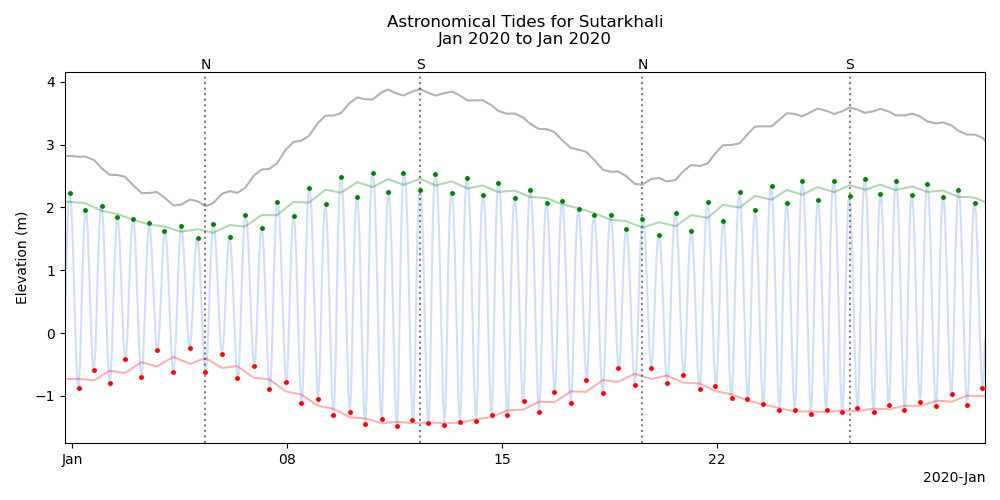

In [6]:
start = pd.to_datetime("2020-01-01").tz_localize(tz="Asia/Dhaka")
end = start + pd.Timedelta("30D")

pdata = tides.loc[start:end].reset_index()

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()

sns.lineplot(data=pdata, x="datetime", y="elevation", color="cornflowerblue", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="high_roll", color="green", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="low_roll", color="red", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="amp_roll", color="black", alpha=0.3, ax=ax)

sns.scatterplot(data=pdata.loc[pdata.high == True], x="datetime", y="elevation", color="green", s=15, ax=ax, zorder=15)
sns.scatterplot(data=pdata.loc[pdata.low == True], x="datetime", y="elevation", color="red", s=15, ax=ax, zorder=15)

for loc in pdata.loc[pdata.spring == True].datetime:
    ax.axvline(x=loc, color="black", linestyle="dotted", alpha=0.5)
    ax.text(x=loc, y=ax.get_ylim()[1], s="S", rotation=0, ha="center", va="bottom")

for loc in pdata.loc[pdata.neap == True].datetime:
    ax.axvline(x=loc, color="black", linestyle="dotted", alpha=0.5)
    ax.text(x=loc, y=ax.get_ylim()[1], s="N", rotation=0, ha="center", va="bottom")

title = "Astronomical Tides for Sutarkhali\n{} to {}".format(start.strftime("%b %Y"), end.strftime("%b %Y"))
xlabel = ""
ylabel = "Elevation (m)"
rotation = 0

locator = locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

ax.xaxis.set(major_locator=locator, major_formatter=formatter)
ax.tick_params(axis='x', labelrotation=rotation)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.set_title(label=title, pad=20)
ax.set_xlim(start, end)
fig.tight_layout()

In [7]:
springs = tides.loc[tides.spring == True].apply(
    lambda x: pd.Series(data=(
        tides.loc[tides.high == True].elev_adj.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean(),
        tides.loc[tides.low == True].elev_adj.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean()),
        index=("high", "low")),
        axis=1)

neaps = tides.loc[tides.neap == True].apply(
    lambda x: pd.Series(data=(
        tides.loc[tides.high == True].elev_adj.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean(),
        tides.loc[tides.low == True].elev_adj.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean()),
        index=("high", "low")),
        axis=1)

In [8]:
springs_yearly = springs.groupby(by=pd.Grouper(freq="AS")).mean().set_index(springs.index.year.unique())

In [9]:
window = pd.Timedelta("14 days")
tides["mean_roll"] = tides.elev_adj.rolling(window=window, center=True).mean()
beta_sh = 11.9e-3
beta_sl = 3.9e-3

In [10]:
tides["elev_amp"] = np.nan
tides.loc[tides.elev_adj > tides.mean_roll, "elev_amp"] = tides.loc[tides.elev_adj > tides.mean_roll].apply(
    lambda row: row.elev_adj + row.elev_adj / springs_yearly.high.loc[row.name.year] * beta_sh * row.elapsed / pd.Timedelta("365.25 days"),
    axis=1)

tides.loc[tides.elev_adj < tides.mean_roll, "elev_amp"] = tides.loc[tides.elev_adj < tides.mean_roll].apply(
    lambda row: row.elev_adj - row.elev_adj / springs_yearly.low.loc[row.name.year] * beta_sl * row.elapsed / pd.Timedelta("365.25 days"),
    axis=1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
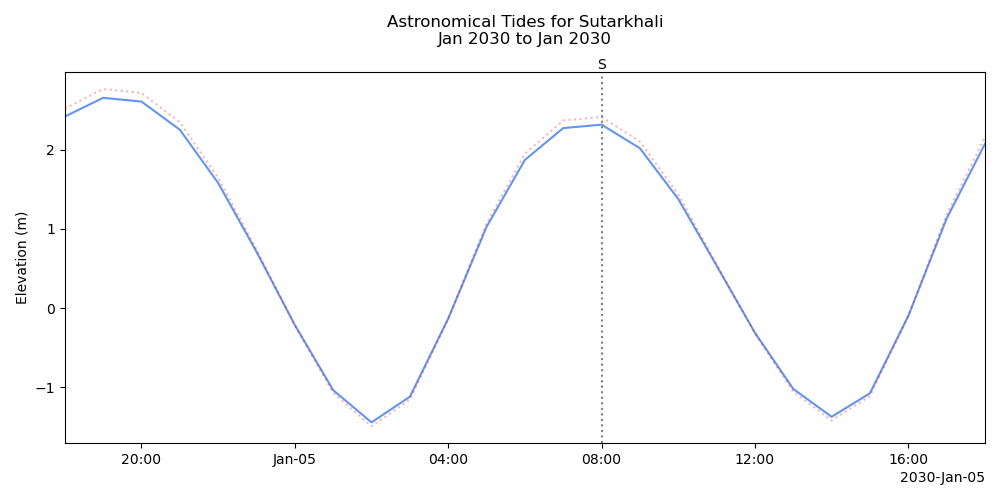

In [11]:
start = pd.to_datetime("2030-01-05").tz_localize(tz="Asia/Dhaka")
end = start + pd.Timedelta("1D")

pdata = tides.loc[start:end].reset_index()

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()

sns.lineplot(data=pdata, x="datetime", y="elev_adj", color="cornflowerblue", alpha=1, ax=ax, zorder=1)
sns.lineplot(data=pdata, x="datetime", y="elev_amp", color="red", linestyle="dotted", alpha=0.3, ax=ax, zorder=10)

# sns.scatterplot(data=pdata.loc[pdata.high == True], x="datetime", y="elevation", color="green", s=15, ax=ax, zorder=15)
# sns.scatterplot(data=pdata.loc[pdata.low == True], x="datetime", y="elevation", color="red", s=15, ax=ax, zorder=15)

for loc in pdata.loc[pdata.spring == True].datetime:
    ax.axvline(x=loc, color="black", linestyle="dotted", alpha=0.5)
    ax.text(x=loc, y=ax.get_ylim()[1], s="S", rotation=0, ha="center", va="bottom")

for loc in pdata.loc[pdata.neap == True].datetime:
    ax.axvline(x=loc, color="black", linestyle="dotted", alpha=0.5)
    ax.text(x=loc, y=ax.get_ylim()[1], s="N", rotation=0, ha="center", va="bottom")

title = "Astronomical Tides for Sutarkhali\n{} to {}".format(start.strftime("%b %Y"), end.strftime("%b %Y"))
xlabel = ""
ylabel = "Elevation (m)"
rotation = 0

locator = locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

ax.xaxis.set(major_locator=locator, major_formatter=formatter)
ax.tick_params(axis='x', labelrotation=rotation)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.set_title(label=title, pad=20)
ax.set_xlim(start, end)
fig.tight_layout()

In [12]:
def lm_tides(data, ref_date, time_unit="365.25 days"):

    x = ((data.index - ref_date) / pd.Timedelta(time_unit)).values.reshape(-1, 1)
    y = data.values.reshape(-1, 1)
    lm = LinearRegression().fit(x, y)

    y_pred = lm.predict(x)

    ts = pd.Series(data=y_pred.flatten(), index=data.index)

    index = ("lm", "coef", "intercept", "TS")
    data = (lm, lm.coef_[0, 0], lm.intercept_[0], ts)

    s = pd.Series(data=data, index=index)

    return(s)

In [15]:
subset = tides

In [16]:
springs = subset.loc[subset.spring == True].apply(
    lambda x: pd.Series(data=(
        subset.loc[subset.high == True].elev_adj.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean(),
        subset.loc[subset.low == True].elev_adj.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean()),
        index=("high", "low")),
        axis=1)

neaps = subset.loc[subset.neap == True].apply(
    lambda x: pd.Series(data=(
        subset.loc[subset.high == True].elev_adj.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean(),
        subset.loc[subset.low == True].elev_adj.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean()),
        index=("high", "low")),
        axis=1)

In [17]:
spring_lm = springs.dropna().apply(lambda x: lm_tides(data=x, ref_date=subset.index[0], time_unit="365.25 days"))
neap_lm = neaps.dropna().apply(lambda x: lm_tides(data=x, ref_date=subset.index[0], time_unit="365.25 days"))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
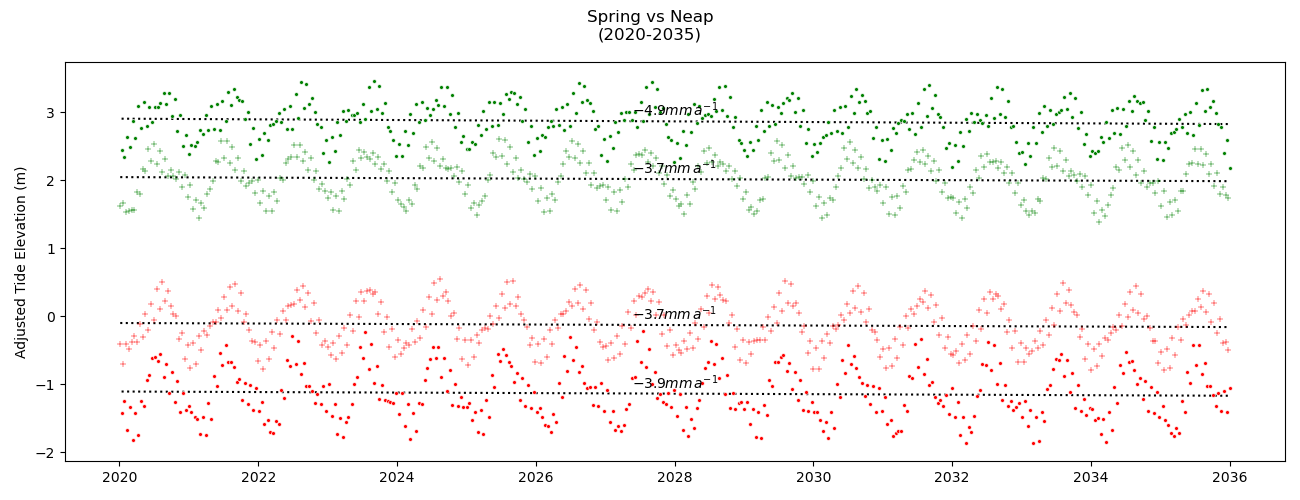

In [18]:
fig = plt.figure(figsize=(13, 5))
ax = fig.subplots()

sns.scatterplot(data=springs.reset_index(), x="datetime", y="high", color="green", marker=".", s=30, ax=ax, zorder=15)
sns.scatterplot(data=neaps.reset_index(), x="datetime", y="high", color="green", marker="+", s=20, ax=ax, zorder=15)
sns.scatterplot(data=springs.reset_index(), x="datetime", y="low", color="red", marker=".", s=30, ax=ax, zorder=15)
sns.scatterplot(data=neaps.reset_index(), x="datetime", y="low", color="red", marker="+", s=20, ax=ax, zorder=15)

sns.lineplot(data=spring_lm.high.TS, color="black", linestyle="dotted", ax=ax, zorder=1)
sns.lineplot(data=neap_lm.high.TS, color="black", linestyle="dotted", ax=ax, zorder=1)
sns.lineplot(data=spring_lm.low.TS, color="black", linestyle="dotted", ax=ax, zorder=1)
sns.lineplot(data=neap_lm.low.TS, color="black", linestyle="dotted", ax=ax, zorder=1)

ax.text(x=spring_lm.high.TS.index.mean(), y=spring_lm.high.TS.max(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(spring_lm.high.coef * 1000), fontsize="medium")
ax.text(x=neap_lm.high.TS.index.mean(), y=neap_lm.high.TS.max(), ha="center", va="bottom", zorder=20, s="${:+.1f} mm \, a^{{-1}}$".format(neap_lm.high.coef * 1000), fontsize="medium")
ax.text(x=spring_lm.low.TS.index.mean(), y=spring_lm.low.TS.max(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(spring_lm.low.coef * 1000), fontsize="medium")
ax.text(x=neap_lm.low.TS.index.mean(), y=neap_lm.low.TS.max(), ha="center", va="bottom", zorder=20, s="${:+.1f} mm \, a^{{-1}}$".format(neap_lm.low.coef * 1000), fontsize="medium")

ax.set(xlabel="", ylabel="Adjusted Tide Elevation (m)")

title = "Spring vs Neap\n({}-{})".format(subset.index[0].year, subset.index[-1].year)
fig.suptitle(t=title)

fig.tight_layout()

In [19]:
window = pd.Timedelta("14 days")
tides["mean_roll"] = tides.elevation.rolling(window=window, center=True).mean()
tides["sh_roll"] = springs.high.rolling(window=window, center=True).mean().reindex(index=tides.index).interpolate(method="time", limit_direction="both")
tides["sl_roll"] = springs.low.rolling(window=window, center=True).mean().reindex(index=tides.index).interpolate(method="time", limit_direction="both")
tides["nh_roll"] = neaps.high.rolling(window=window, center=True).mean().reindex(index=tides.index).interpolate(method="time", limit_direction="both")
tides["nl_roll"] = neaps.low.rolling(window=window, center=True).mean().reindex(index=tides.index).interpolate(method="time", limit_direction="both")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
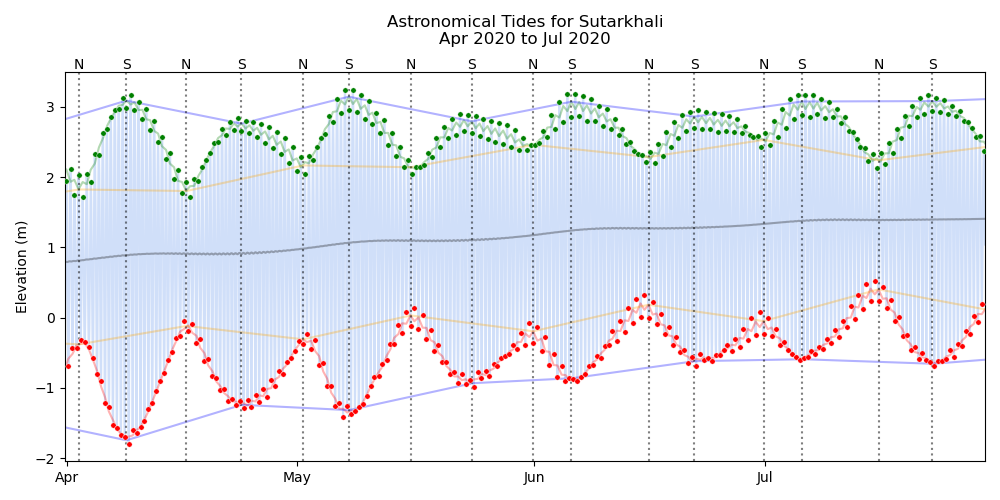

In [20]:
start = pd.to_datetime("2020-04-01").tz_localize(tz="Asia/Dhaka")
end = start + pd.Timedelta("120D")

pdata = tides.loc[start:end]
pdata_resample = pdata.resample(rule=pd.Timedelta("30 min", on="datetime")).first().reset_index()
pdata = pdata.reset_index()

fig = plt.figure(figsize=(10, 5))
ax = fig.subplots()

sns.lineplot(data=pdata_resample, x="datetime", y="elevation", color="cornflowerblue", alpha=0.3, ax=ax)
sns.lineplot(data=pdata_resample, x="datetime", y="high_roll", color="green", alpha=0.3, ax=ax)
sns.lineplot(data=pdata_resample, x="datetime", y="low_roll", color="red", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="mean_roll", color="black", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="sh_roll", color="blue", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="sl_roll", color="blue", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="nh_roll", color="orange", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="nl_roll", color="orange", alpha=0.3, ax=ax)

sns.scatterplot(data=pdata.loc[pdata.high == True], x="datetime", y="elevation", color="green", s=15, ax=ax, zorder=15)
sns.scatterplot(data=pdata.loc[pdata.low == True], x="datetime", y="elevation", color="red", s=15, ax=ax, zorder=15)

for loc in pdata.loc[pdata.spring == True].datetime:
    ax.axvline(x=loc, color="black", linestyle="dotted", alpha=0.5)
    ax.text(x=loc, y=ax.get_ylim()[1], s="S", rotation=0, ha="center", va="bottom")

for loc in pdata.loc[pdata.neap == True].datetime:
    ax.axvline(x=loc, color="black", linestyle="dotted", alpha=0.5)
    ax.text(x=loc, y=ax.get_ylim()[1], s="N", rotation=0, ha="center", va="bottom")

title = "Astronomical Tides for Sutarkhali\n{} to {}".format(start.strftime("%b %Y"), end.strftime("%b %Y"))
xlabel = ""
ylabel = "Elevation (m)"
rotation = 0

locator = locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

ax.xaxis.set(major_locator=locator, major_formatter=formatter)
ax.tick_params(axis='x', labelrotation=rotation)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.set_title(label=title, pad=20)
ax.set_xlim(start, end)
fig.tight_layout()

In [21]:
tides["beta_sh"] = tides.elapsed / pd.Timedelta("365.25 days") * 11.9e-3
tides["beta_sl"] = tides.elapsed / pd.Timedelta("365.25 days") * 3.9e-3
tides["beta_nh"] = tides.elapsed / pd.Timedelta("365.25 days") * -4.1e-3
tides["beta_nl"] = tides.elapsed / pd.Timedelta("365.25 days")* -13.3e-3

In [22]:
# subset highs and lows
highs = tides.loc[tides.high == True][["elapsed", "elevation", "nodal"]]
lows = tides.loc[subset.low == True][["elapsed", "elevation", "nodal"]]

# remove nodal tide
highs["elev_adj"] = highs.elevation - highs.nodal
lows["elev_adj"] = lows.elevation - lows.nodal

# add column of beta adjustments
highs["beta_spring"] = highs.elapsed / pd.Timedelta("1Y") * spring_lm.HW_adj.coef
highs["beta_neap"] = highs.elapsed / pd.Timedelta("1Y") * neap_lm.HW_adj.coef

lows["beta_spring"] = lows.elapsed / pd.Timedelta("1Y") * spring_lm.LW_adj.coef
lows["beta_neap"] = lows.elapsed / pd.Timedelta("1Y") * neap_lm.LW_adj.coef

# merge into one df
nodes = pd.concat([highs, lows], keys=("high", "low"), names=("type", "datetime")).reset_index(level=["type"]).sort_index()

/opt/conda/envs/python/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


AttributeError: 'DataFrame' object has no attribute 'HW_adj'

In [ ]:
spring_prox = np.empty(0)
for loc in nodes.index:
    spring_loc = subset.loc[subset.spring == True].iloc[subset.loc[subset.spring == True].index.get_loc(loc, method="nearest")].name
    spring_prox = np.append(arr=spring_prox, values=abs(loc - spring_loc))

In [ ]:
nodes["amp_factor"] = (100 - pd.qcut(x=spring_prox / pd.Timedelta("1D"), q=100, labels=False)) / 100
nodes["elev_amp"] = nodes.elev_adj + (nodes.beta_spring - nodes.beta_neap) * nodes.amp_factor + nodes.beta_neap

In [ ]:
df1 = nodes[["type", "elev_adj", "elev_amp"]].rename(columns={"elev_adj": "old", "elev_amp": "new"})
df1 = df1.append([{"datetime": (df1.datetime.iat[0] - df1.datetime.diff().mean()).round("30S")}][])

In [ ]:
df1.loc["1999-03-25":]

In [ ]:
df1.join(df1.index.to_series().diff()).datetime.sort_values(ascending=False)

In [ ]:
fig = plt.figure(figsize=(13, 5))
ax = fig.subplots()

sns.histplot(data=df1.join(df1.index.to_series().diff()).datetime / pd.Timedelta("1D"))

In [ ]:
df2 = df1.join(other=df1.shift(-1), lsuffix="_1", rsuffix="_2").rename(columns={"datetime_1": "start", "datetime_2": "stop"})

In [ ]:
lows.append([{"datetime": (lows.datetime.iat[0] - lows.datetime.diff().mean()).round("30S")}]).sort_values("datetime").reset_index(drop=True)

In [ ]:
tides = subset
highs = nodes.loc[nodes.type=="high"].reset_index()[["datetime", "elev_amp"]]
highs = highs.append([{"datetime": (highs.datetime.iat[-1] + highs.datetime.diff().mean()).round("30S")}]).sort_values("datetime").reset_index(drop=True)
highs["elapsed_yr"] = (highs.datetime - tides.index[0]).dt.total_seconds() / pd.Timedelta(days=365).total_seconds()
lows = nodes.loc[nodes.type=="low"].reset_index()[["datetime", "elev_amp"]]
lows = lows.append([{"datetime": (lows.datetime.iat[0] - lows.datetime.diff().mean()).round("30S")}]).sort_values("datetime").reset_index(drop=True)
lows["elapsed_yr"] = (lows.datetime - tides.index[0]).dt.total_seconds() / pd.Timedelta(days=365).total_seconds()

low_subset = lows.iloc[::2].iloc[1:]
low_interp = interp1d(x=low_subset.elapsed_yr, y=low_subset.elev_amp, fill_value="extrapolate", kind="linear")
lows.loc[0, "elev_amp"] = low_interp(lows.elapsed_yr.iat[0])

high_subset = highs.iloc[1::2].iloc[:-1]
high_interp = interp1d(x=high_subset.elapsed_yr, y=high_subset.elev_amp, fill_value="extrapolate", kind="linear")
highs.loc[highs.index[-1], "elev_amp"] = high_interp(highs.elapsed_yr.iat[-1])

df1 = lows.join(other=highs, lsuffix="_low", rsuffix="_high").drop(columns=["elapsed_yr_high", "elapsed_yr_low"])
df1["type"] = "low-high"

df2 = highs[:-1].join(other=lows.shift(-1)[:-1], lsuffix="_high", rsuffix="_low").drop(columns=["elapsed_yr_high", "elapsed_yr_low"])
df2["type"] = "high-low"

df1.columns = ["start", "low", "stop", "high", "type"]
df2.columns = ["start", "high", "stop", "low", "type"]


df = pd.concat(objs=[df1, df2]).set_index("start").sort_index().reset_index()

# df = df[["start", "stop", "type", "high_old", "high_new", "low_old", "low_new"]]
# df.index.name = "tide"

In [ ]:
highs

In [ ]:
tides = subset
highs = nodes.loc[nodes.type=="high"].reset_index()[["datetime", "elevation"]]
highs = highs.append([{"datetime": (highs.datetime.iat[-1] + highs.datetime.diff().mean()).round("30S")}]).sort_values("datetime").reset_index(drop=True)
highs["elapsed_yr"] = (highs.datetime - tides.index[0]).dt.total_seconds() / pd.Timedelta(days=365).total_seconds()
lows = nodes.loc[nodes.type=="low"].reset_index()[["datetime", "elevation"]]
lows = lows.append([{"datetime": (lows.datetime.iat[0] - lows.datetime.diff().mean()).round("30S")}]).sort_values("datetime").reset_index(drop=True)
lows["elapsed_yr"] = (lows.datetime - tides.index[0]).dt.total_seconds() / pd.Timedelta(days=365).total_seconds()

low_subset = lows.iloc[::2].iloc[1:]
low_interp = interp1d(x=low_subset.elapsed_yr, y=low_subset.elevation, fill_value="extrapolate", kind="linear")
lows.loc[0, "elevation"] = low_interp(lows.elapsed_yr.iat[0])

high_subset = highs.iloc[1::2].iloc[:-1]
high_interp = interp1d(x=high_subset.elapsed_yr, y=high_subset.elevation, fill_value="extrapolate", kind="linear")
highs.loc[highs.index[-1], "elevation"] = high_interp(highs.elapsed_yr.iat[-1])

highs["elevation_new"] = highs.elevation + highs.elapsed_yr * beta_mean_high
lows["elevation_new"] = lows.elevation + lows.elapsed_yr * beta_mean_low

df1 = lows.join(other=highs, lsuffix="_low", rsuffix="_high").drop(columns=["elapsed_yr_high", "elapsed_yr_low"])
df1["type"] = "low-high"

df2 = highs[:-1].join(other=lows.shift(-1)[:-1], lsuffix="_high", rsuffix="_low").drop(columns=["elapsed_yr_high", "elapsed_yr_low"])
df2["type"] = "high-low"

df1.columns = ["start", "low_old", "low_new", "stop", "high_old", "high_new", "type"]
df2.columns = ["start", "high_old", "high_new", "stop", "low_old", "low_new", "type"]


df = pd.concat(objs=[df1, df2]).set_index("start").sort_index().reset_index()

df = df[["start", "stop", "type", "high_old", "high_new", "low_old", "low_new"]]
df.index.name = "tide"

In [ ]:
def stretch_limb(limb, old_range: list(), new_range: list()):
    tide = limb.copy()
    tide["elevation"] = new_range[0] + ((tide.elevation - old_range[0]) * (new_range[1] - new_range[0])) / (tide.elevation.max() - old_range[0])
    return tide

In [ ]:
new = Parallel(n_jobs=-1)(delayed(stretch_limb)(
    limb=tides.loc[row.start:row.stop],
    old_range=[row.low_old, row.high_old],
    new_range=[row.low_new, row.high_new]
    ) for row in df.itertuples())
tides_new = pd.concat(new).reset_index().drop_duplicates(subset=["datetime"]).set_index("datetime").sort_index()

In [ ]:
nodal_amp = 0.045
nodal_freq = 18.61
nodal = nodal_amp * np.sin(2*np.pi*(s.index - pd.to_datetime("2015-10-01")) / (pd.Timedelta("365.25 days") * nodal_freq) + np.pi / 2)
s = s - nodal
df = s.groupby(pd.Grouper(freq="AS")).apply(lambda x: x.quantile(q=np.arange(0,1.1,0.1))).unstack(0)
df.columns = df.columns.year
df.columns.name = "year"
df.index.name = "quantile"

In [ ]:
s = data.loc["1998":].elevation.copy()

nodal_amp = 0.045
nodal_freq = 18.61
nodal = nodal_amp * np.sin(2*np.pi*(s.index - pd.to_datetime("2015-10-01")) / (pd.Timedelta("365.25 days") * nodal_freq) + np.pi / 2)
s = s - nodal
quants = np.arange(0, 1.01, 0.01)
df = s.groupby(pd.Grouper(freq="AS")).apply(lambda x: x.quantile(q=quants)).unstack(0)

df.index = df.index.values.round(2)
df.columns = df.columns.year
df.columns.name = "year"
df.index.name = "quantile"

fig = plt.figure(figsize=(15, 5))
ax = fig.subplots()

sns.heatmap(df.T.sort_index(ascending=False), xticklabels=10, cmap="mako", ax=ax)

In [ ]:
s = data.loc["1998":].elevation.copy()

nodal_amp = 0.045
nodal_freq = 18.61
nodal = nodal_amp * np.sin(2*np.pi*(s.index - pd.to_datetime("2015-10-01")) / (pd.Timedelta("365.25 days") * nodal_freq) + np.pi / 2)
s = s - nodal

sd = s.groupby(by=pd.Grouper(freq="D")).mean().interpolate(method="time", limit_direction="both")
res = STL(endog=sd, trend=365).fit()
seasonal = res.trend.reindex(index=s.index).interpolate(method="time", limit_direction="both")

s = s - seasonal

df = s.to_frame(name="elevation")
df["year"] = df.index.year
df["timedelta"] = df.index - pd.to_datetime(df.index.year, format="%Y")
df = df.groupby(["year", "timedelta"]).mean().unstack(0)
df.index = (df.index / pd.Timedelta(days=1)).values.round(2)
df.columns = df.columns.droplevel(0)

fig = plt.figure(figsize=(18, 5))
ax = fig.subplots()

pdata = df

sns.heatmap(pdata.T.sort_index(ascending=False), xticklabels=df.index.size//6, cmap="mako", robust=True, ax=ax)
plt.tight_layout()